# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

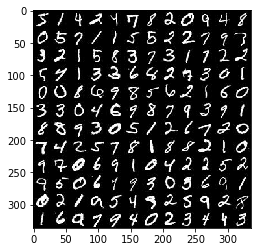

In [2]:
show_n_images = 152

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

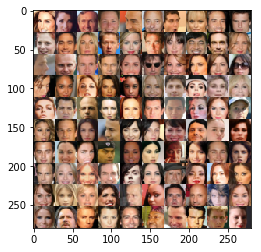

In [3]:
show_n_images = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [15]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha=0.2
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [56]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha=0.2
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [57]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [58]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [66]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [69]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Reference: https://discussions.udacity.com/t/need-help-for-mnist-training/413800/6
    
    # TODO: Build Model
    image_width, image_height, image_channels = data_shape[1], data_shape[2], data_shape[3]
    out_channel_dim = data_shape[3]
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    print_every=10
    show_every=100
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: sample_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: sample_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9056... Generator Loss: 0.9148
Epoch 1/2... Discriminator Loss: 0.9143... Generator Loss: 0.9283
Epoch 1/2... Discriminator Loss: 1.6404... Generator Loss: 0.4545
Epoch 1/2... Discriminator Loss: 1.5355... Generator Loss: 0.3710
Epoch 1/2... Discriminator Loss: 1.1629... Generator Loss: 1.2879
Epoch 1/2... Discriminator Loss: 1.2661... Generator Loss: 0.6216
Epoch 1/2... Discriminator Loss: 1.5189... Generator Loss: 2.3308
Epoch 1/2... Discriminator Loss: 0.6674... Generator Loss: 2.3771
Epoch 1/2... Discriminator Loss: 0.6426... Generator Loss: 1.8913
Epoch 1/2... Discriminator Loss: 0.4338... Generator Loss: 2.2560


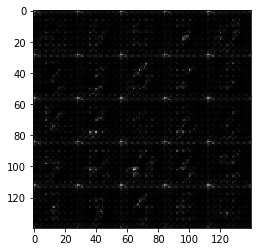

Epoch 1/2... Discriminator Loss: 1.3618... Generator Loss: 4.7885
Epoch 1/2... Discriminator Loss: 0.3142... Generator Loss: 2.3933
Epoch 1/2... Discriminator Loss: 0.1733... Generator Loss: 2.5020
Epoch 1/2... Discriminator Loss: 0.1639... Generator Loss: 2.5339
Epoch 1/2... Discriminator Loss: 0.2158... Generator Loss: 3.1353
Epoch 1/2... Discriminator Loss: 0.5533... Generator Loss: 4.6913
Epoch 1/2... Discriminator Loss: 0.0965... Generator Loss: 2.8399
Epoch 1/2... Discriminator Loss: 0.1273... Generator Loss: 2.6954
Epoch 1/2... Discriminator Loss: 0.1073... Generator Loss: 2.5884
Epoch 1/2... Discriminator Loss: 0.0734... Generator Loss: 3.4066


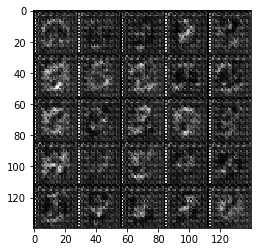

Epoch 1/2... Discriminator Loss: 0.1316... Generator Loss: 2.8005
Epoch 1/2... Discriminator Loss: 0.5075... Generator Loss: 1.4921
Epoch 1/2... Discriminator Loss: 0.1200... Generator Loss: 4.4732
Epoch 1/2... Discriminator Loss: 0.0335... Generator Loss: 4.9306
Epoch 1/2... Discriminator Loss: 2.6334... Generator Loss: 6.5921
Epoch 1/2... Discriminator Loss: 0.9488... Generator Loss: 0.6549
Epoch 1/2... Discriminator Loss: 0.4598... Generator Loss: 1.6445
Epoch 1/2... Discriminator Loss: 0.0897... Generator Loss: 3.5170
Epoch 1/2... Discriminator Loss: 0.2949... Generator Loss: 2.6643
Epoch 1/2... Discriminator Loss: 1.2243... Generator Loss: 0.5432


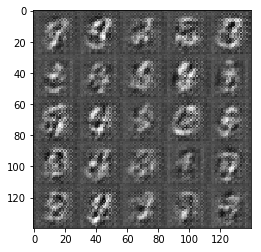

Epoch 1/2... Discriminator Loss: 0.3544... Generator Loss: 2.2642
Epoch 1/2... Discriminator Loss: 1.3061... Generator Loss: 3.9763
Epoch 1/2... Discriminator Loss: 0.5965... Generator Loss: 2.1883
Epoch 1/2... Discriminator Loss: 0.8448... Generator Loss: 1.0239
Epoch 1/2... Discriminator Loss: 0.3443... Generator Loss: 3.1548
Epoch 1/2... Discriminator Loss: 0.3215... Generator Loss: 2.7816
Epoch 1/2... Discriminator Loss: 1.1639... Generator Loss: 3.9443
Epoch 1/2... Discriminator Loss: 0.2888... Generator Loss: 1.9472
Epoch 1/2... Discriminator Loss: 0.7036... Generator Loss: 3.6846
Epoch 1/2... Discriminator Loss: 0.3645... Generator Loss: 3.1510


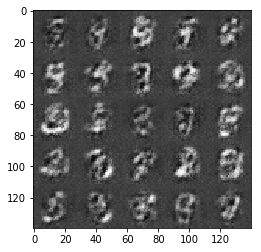

Epoch 1/2... Discriminator Loss: 0.3932... Generator Loss: 3.7086
Epoch 1/2... Discriminator Loss: 1.3836... Generator Loss: 0.3847
Epoch 1/2... Discriminator Loss: 1.1225... Generator Loss: 4.3488
Epoch 1/2... Discriminator Loss: 0.2082... Generator Loss: 2.2482
Epoch 1/2... Discriminator Loss: 0.2351... Generator Loss: 2.6845
Epoch 1/2... Discriminator Loss: 0.2468... Generator Loss: 2.9817
Epoch 2/2... Discriminator Loss: 0.3679... Generator Loss: 1.5015
Epoch 2/2... Discriminator Loss: 0.1962... Generator Loss: 2.3866
Epoch 2/2... Discriminator Loss: 0.3610... Generator Loss: 1.6455
Epoch 2/2... Discriminator Loss: 0.2336... Generator Loss: 2.3504


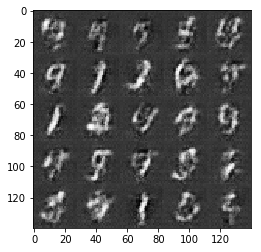

Epoch 2/2... Discriminator Loss: 0.1280... Generator Loss: 2.9749
Epoch 2/2... Discriminator Loss: 0.2387... Generator Loss: 3.5955
Epoch 2/2... Discriminator Loss: 0.2204... Generator Loss: 4.3086
Epoch 2/2... Discriminator Loss: 0.3033... Generator Loss: 1.8201
Epoch 2/2... Discriminator Loss: 0.1986... Generator Loss: 2.8288
Epoch 2/2... Discriminator Loss: 0.1714... Generator Loss: 2.3676
Epoch 2/2... Discriminator Loss: 0.2199... Generator Loss: 1.9784
Epoch 2/2... Discriminator Loss: 0.3168... Generator Loss: 2.5241
Epoch 2/2... Discriminator Loss: 0.2504... Generator Loss: 2.3255
Epoch 2/2... Discriminator Loss: 0.1624... Generator Loss: 2.4652


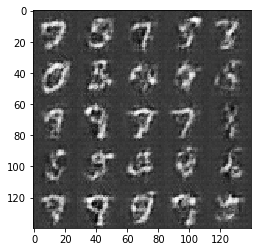

Epoch 2/2... Discriminator Loss: 0.1470... Generator Loss: 2.5994
Epoch 2/2... Discriminator Loss: 0.1605... Generator Loss: 2.4961
Epoch 2/2... Discriminator Loss: 0.2283... Generator Loss: 1.9316
Epoch 2/2... Discriminator Loss: 0.1277... Generator Loss: 2.6331
Epoch 2/2... Discriminator Loss: 1.7056... Generator Loss: 0.3017
Epoch 2/2... Discriminator Loss: 0.5328... Generator Loss: 2.2800
Epoch 2/2... Discriminator Loss: 0.2914... Generator Loss: 2.1587
Epoch 2/2... Discriminator Loss: 0.2415... Generator Loss: 2.5374
Epoch 2/2... Discriminator Loss: 0.1511... Generator Loss: 2.9406
Epoch 2/2... Discriminator Loss: 0.2818... Generator Loss: 3.2496


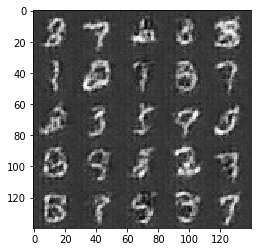

Epoch 2/2... Discriminator Loss: 0.1381... Generator Loss: 3.1722
Epoch 2/2... Discriminator Loss: 0.0644... Generator Loss: 4.0243
Epoch 2/2... Discriminator Loss: 0.1551... Generator Loss: 2.3614
Epoch 2/2... Discriminator Loss: 0.1062... Generator Loss: 5.1992
Epoch 2/2... Discriminator Loss: 1.8833... Generator Loss: 9.8826
Epoch 2/2... Discriminator Loss: 0.2042... Generator Loss: 2.4204
Epoch 2/2... Discriminator Loss: 0.1066... Generator Loss: 2.9783
Epoch 2/2... Discriminator Loss: 0.2701... Generator Loss: 1.7358
Epoch 2/2... Discriminator Loss: 0.0862... Generator Loss: 4.0873
Epoch 2/2... Discriminator Loss: 0.0810... Generator Loss: 3.9009


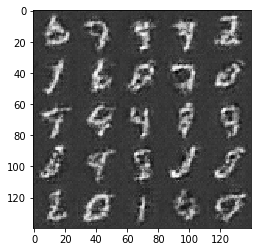

Epoch 2/2... Discriminator Loss: 0.1141... Generator Loss: 3.1422
Epoch 2/2... Discriminator Loss: 0.0801... Generator Loss: 3.0596
Epoch 2/2... Discriminator Loss: 0.0917... Generator Loss: 3.0434
Epoch 2/2... Discriminator Loss: 0.0488... Generator Loss: 3.8262
Epoch 2/2... Discriminator Loss: 6.5390... Generator Loss: 6.4980
Epoch 2/2... Discriminator Loss: 0.5793... Generator Loss: 1.7277
Epoch 2/2... Discriminator Loss: 0.5942... Generator Loss: 2.2354
Epoch 2/2... Discriminator Loss: 0.4258... Generator Loss: 2.9115
Epoch 2/2... Discriminator Loss: 0.2875... Generator Loss: 2.9023
Epoch 2/2... Discriminator Loss: 0.2775... Generator Loss: 2.7154


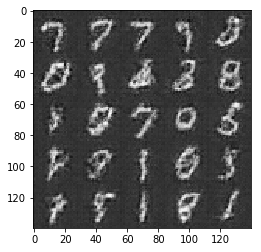

Epoch 2/2... Discriminator Loss: 0.3205... Generator Loss: 1.8661
Epoch 2/2... Discriminator Loss: 0.2011... Generator Loss: 3.1403
Epoch 2/2... Discriminator Loss: 0.1746... Generator Loss: 2.6931


In [63]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 0.6135... Generator Loss: 2.4852
Epoch 1/1... Discriminator Loss: 0.4005... Generator Loss: 2.1758
Epoch 1/1... Discriminator Loss: 0.5647... Generator Loss: 2.8444
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 1.4152
Epoch 1/1... Discriminator Loss: 0.6099... Generator Loss: 2.2044
Epoch 1/1... Discriminator Loss: 0.6410... Generator Loss: 2.5437
Epoch 1/1... Discriminator Loss: 0.3562... Generator Loss: 1.8853
Epoch 1/1... Discriminator Loss: 0.4158... Generator Loss: 1.2476
Epoch 1/1... Discriminator Loss: 0.3739... Generator Loss: 1.3616


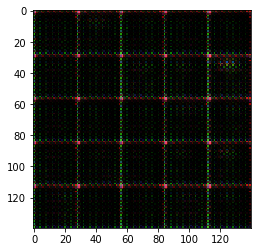

Epoch 1/1... Discriminator Loss: 0.7927... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 0.1660... Generator Loss: 2.4771
Epoch 1/1... Discriminator Loss: 0.0712... Generator Loss: 3.4801
Epoch 1/1... Discriminator Loss: 0.5980... Generator Loss: 6.7153
Epoch 1/1... Discriminator Loss: 0.3035... Generator Loss: 1.6143
Epoch 1/1... Discriminator Loss: 0.5320... Generator Loss: 2.8451
Epoch 1/1... Discriminator Loss: 0.6644... Generator Loss: 1.1503
Epoch 1/1... Discriminator Loss: 2.0152... Generator Loss: 0.2528
Epoch 1/1... Discriminator Loss: 0.5793... Generator Loss: 3.8404
Epoch 1/1... Discriminator Loss: 0.1081... Generator Loss: 3.2343


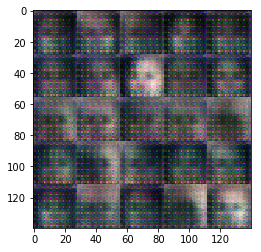

Epoch 1/1... Discriminator Loss: 0.1942... Generator Loss: 2.5171
Epoch 1/1... Discriminator Loss: 0.1821... Generator Loss: 3.0595
Epoch 1/1... Discriminator Loss: 0.1855... Generator Loss: 3.1364
Epoch 1/1... Discriminator Loss: 0.1268... Generator Loss: 4.8125
Epoch 1/1... Discriminator Loss: 0.3291... Generator Loss: 3.7723
Epoch 1/1... Discriminator Loss: 0.5241... Generator Loss: 5.2114
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 0.5077
Epoch 1/1... Discriminator Loss: 3.1271... Generator Loss: 8.2852
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.5803
Epoch 1/1... Discriminator Loss: 0.4052... Generator Loss: 5.7274


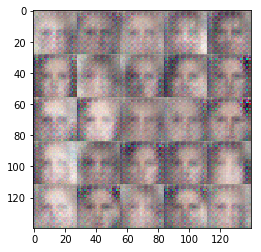

Epoch 1/1... Discriminator Loss: 2.7365... Generator Loss: 8.9516
Epoch 1/1... Discriminator Loss: 0.7063... Generator Loss: 1.1266
Epoch 1/1... Discriminator Loss: 0.1607... Generator Loss: 5.8814
Epoch 1/1... Discriminator Loss: 2.3532... Generator Loss: 0.1471
Epoch 1/1... Discriminator Loss: 2.2812... Generator Loss: 8.9792
Epoch 1/1... Discriminator Loss: 2.4789... Generator Loss: 6.0895
Epoch 1/1... Discriminator Loss: 0.6246... Generator Loss: 1.7621
Epoch 1/1... Discriminator Loss: 0.1859... Generator Loss: 2.6791
Epoch 1/1... Discriminator Loss: 0.1490... Generator Loss: 3.1343
Epoch 1/1... Discriminator Loss: 0.3996... Generator Loss: 1.3399


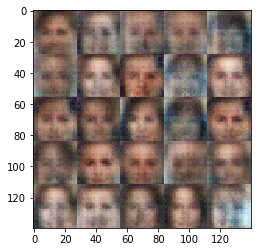

Epoch 1/1... Discriminator Loss: 0.0819... Generator Loss: 5.4638
Epoch 1/1... Discriminator Loss: 0.0995... Generator Loss: 2.9440
Epoch 1/1... Discriminator Loss: 0.1536... Generator Loss: 8.8358
Epoch 1/1... Discriminator Loss: 0.1775... Generator Loss: 2.7463
Epoch 1/1... Discriminator Loss: 0.0790... Generator Loss: 4.6272
Epoch 1/1... Discriminator Loss: 0.4826... Generator Loss: 1.1931
Epoch 1/1... Discriminator Loss: 0.1411... Generator Loss: 5.3098
Epoch 1/1... Discriminator Loss: 0.0446... Generator Loss: 11.0896
Epoch 1/1... Discriminator Loss: 0.0321... Generator Loss: 10.5438
Epoch 1/1... Discriminator Loss: 0.2767... Generator Loss: 10.2962


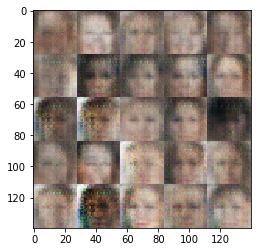

Epoch 1/1... Discriminator Loss: 0.1953... Generator Loss: 2.0306
Epoch 1/1... Discriminator Loss: 0.0203... Generator Loss: 7.9725
Epoch 1/1... Discriminator Loss: 0.0074... Generator Loss: 7.1243
Epoch 1/1... Discriminator Loss: 0.0744... Generator Loss: 2.9240
Epoch 1/1... Discriminator Loss: 0.0112... Generator Loss: 6.1584
Epoch 1/1... Discriminator Loss: 0.0190... Generator Loss: 7.3899
Epoch 1/1... Discriminator Loss: 0.0504... Generator Loss: 7.0722
Epoch 1/1... Discriminator Loss: 3.8290... Generator Loss: 1.1492
Epoch 1/1... Discriminator Loss: 0.5149... Generator Loss: 1.3942
Epoch 1/1... Discriminator Loss: 0.3647... Generator Loss: 5.7925


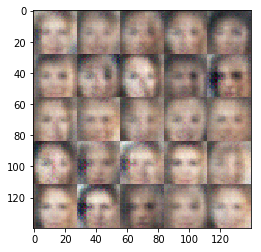

Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.3592
Epoch 1/1... Discriminator Loss: 2.1455... Generator Loss: 0.1825
Epoch 1/1... Discriminator Loss: 0.3033... Generator Loss: 1.8245
Epoch 1/1... Discriminator Loss: 0.3224... Generator Loss: 5.2294
Epoch 1/1... Discriminator Loss: 0.5269... Generator Loss: 1.1873
Epoch 1/1... Discriminator Loss: 0.1997... Generator Loss: 9.1800
Epoch 1/1... Discriminator Loss: 0.8069... Generator Loss: 10.2330
Epoch 1/1... Discriminator Loss: 0.0334... Generator Loss: 6.8064
Epoch 1/1... Discriminator Loss: 0.2708... Generator Loss: 9.3564
Epoch 1/1... Discriminator Loss: 0.0838... Generator Loss: 3.6789


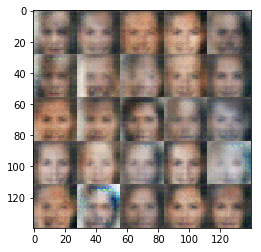

Epoch 1/1... Discriminator Loss: 0.0429... Generator Loss: 8.2262
Epoch 1/1... Discriminator Loss: 0.0743... Generator Loss: 6.7319
Epoch 1/1... Discriminator Loss: 0.9637... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 0.0540... Generator Loss: 4.7562
Epoch 1/1... Discriminator Loss: 0.5324... Generator Loss: 1.0159
Epoch 1/1... Discriminator Loss: 0.1003... Generator Loss: 2.9405
Epoch 1/1... Discriminator Loss: 0.3614... Generator Loss: 1.3327
Epoch 1/1... Discriminator Loss: 0.0251... Generator Loss: 10.6656
Epoch 1/1... Discriminator Loss: 0.4174... Generator Loss: 1.1949
Epoch 1/1... Discriminator Loss: 0.0135... Generator Loss: 6.7040


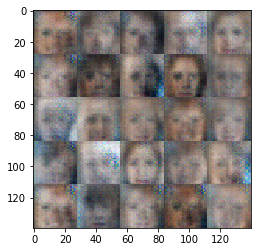

Epoch 1/1... Discriminator Loss: 0.1850... Generator Loss: 2.1453
Epoch 1/1... Discriminator Loss: 0.0494... Generator Loss: 3.5786
Epoch 1/1... Discriminator Loss: 0.0136... Generator Loss: 9.3796
Epoch 1/1... Discriminator Loss: 0.0125... Generator Loss: 9.0732
Epoch 1/1... Discriminator Loss: 0.6620... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 0.0152... Generator Loss: 6.0626
Epoch 1/1... Discriminator Loss: 0.9518... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 0.0118... Generator Loss: 7.9831
Epoch 1/1... Discriminator Loss: 0.1770... Generator Loss: 2.1928
Epoch 1/1... Discriminator Loss: 0.1107... Generator Loss: 2.5931


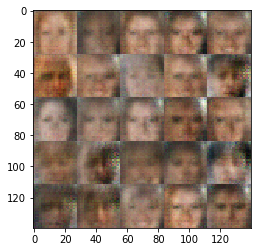

Epoch 1/1... Discriminator Loss: 0.1869... Generator Loss: 2.0647
Epoch 1/1... Discriminator Loss: 0.0119... Generator Loss: 6.8716
Epoch 1/1... Discriminator Loss: 0.0140... Generator Loss: 5.7902
Epoch 1/1... Discriminator Loss: 0.0319... Generator Loss: 3.7712
Epoch 1/1... Discriminator Loss: 0.0074... Generator Loss: 6.3183
Epoch 1/1... Discriminator Loss: 0.0039... Generator Loss: 8.4917
Epoch 1/1... Discriminator Loss: 0.0189... Generator Loss: 4.8514
Epoch 1/1... Discriminator Loss: 0.0124... Generator Loss: 5.9314
Epoch 1/1... Discriminator Loss: 0.0155... Generator Loss: 9.5745
Epoch 1/1... Discriminator Loss: 0.0041... Generator Loss: 7.2598


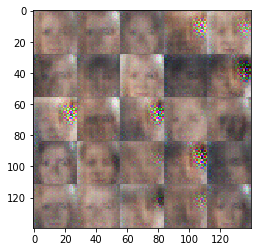

Epoch 1/1... Discriminator Loss: 0.0125... Generator Loss: 5.4501
Epoch 1/1... Discriminator Loss: 0.0312... Generator Loss: 4.1132
Epoch 1/1... Discriminator Loss: 0.0103... Generator Loss: 6.1692
Epoch 1/1... Discriminator Loss: 0.0075... Generator Loss: 7.3851
Epoch 1/1... Discriminator Loss: 0.0054... Generator Loss: 8.6286
Epoch 1/1... Discriminator Loss: 0.0163... Generator Loss: 4.9474
Epoch 1/1... Discriminator Loss: 0.0098... Generator Loss: 6.4458
Epoch 1/1... Discriminator Loss: 0.0100... Generator Loss: 5.9221
Epoch 1/1... Discriminator Loss: 0.0064... Generator Loss: 6.9016
Epoch 1/1... Discriminator Loss: 0.0154... Generator Loss: 10.8262


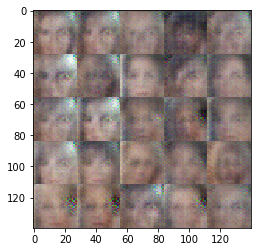

Epoch 1/1... Discriminator Loss: 0.0967... Generator Loss: 2.6518
Epoch 1/1... Discriminator Loss: 0.0126... Generator Loss: 6.7729
Epoch 1/1... Discriminator Loss: 0.0115... Generator Loss: 10.5466
Epoch 1/1... Discriminator Loss: 0.0032... Generator Loss: 7.9118
Epoch 1/1... Discriminator Loss: 0.0045... Generator Loss: 8.2948
Epoch 1/1... Discriminator Loss: 0.0165... Generator Loss: 9.9194
Epoch 1/1... Discriminator Loss: 3.3936... Generator Loss: 6.0840
Epoch 1/1... Discriminator Loss: 0.9021... Generator Loss: 2.1803
Epoch 1/1... Discriminator Loss: 0.0266... Generator Loss: 5.6515
Epoch 1/1... Discriminator Loss: 0.1479... Generator Loss: 2.5333


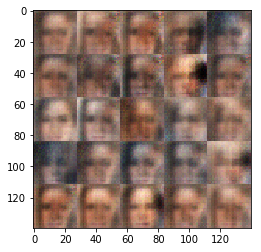

Epoch 1/1... Discriminator Loss: 0.0121... Generator Loss: 6.2782
Epoch 1/1... Discriminator Loss: 0.7358... Generator Loss: 6.2416
Epoch 1/1... Discriminator Loss: 0.5545... Generator Loss: 1.0472
Epoch 1/1... Discriminator Loss: 0.1087... Generator Loss: 3.2453
Epoch 1/1... Discriminator Loss: 0.0477... Generator Loss: 4.3917
Epoch 1/1... Discriminator Loss: 0.0469... Generator Loss: 3.6434
Epoch 1/1... Discriminator Loss: 0.1456... Generator Loss: 4.2579
Epoch 1/1... Discriminator Loss: 0.0603... Generator Loss: 3.5666
Epoch 1/1... Discriminator Loss: 0.0425... Generator Loss: 4.3870
Epoch 1/1... Discriminator Loss: 0.0258... Generator Loss: 8.4305


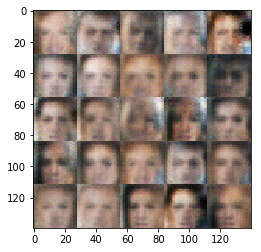

Epoch 1/1... Discriminator Loss: 0.1073... Generator Loss: 7.4550
Epoch 1/1... Discriminator Loss: 0.2977... Generator Loss: 12.6702
Epoch 1/1... Discriminator Loss: 0.0247... Generator Loss: 6.4517
Epoch 1/1... Discriminator Loss: 0.0191... Generator Loss: 6.0470
Epoch 1/1... Discriminator Loss: 0.0282... Generator Loss: 6.9780
Epoch 1/1... Discriminator Loss: 0.1879... Generator Loss: 2.1092
Epoch 1/1... Discriminator Loss: 0.2158... Generator Loss: 2.6280
Epoch 1/1... Discriminator Loss: 0.0152... Generator Loss: 8.8579
Epoch 1/1... Discriminator Loss: 0.0125... Generator Loss: 7.6683
Epoch 1/1... Discriminator Loss: 0.4345... Generator Loss: 1.4492


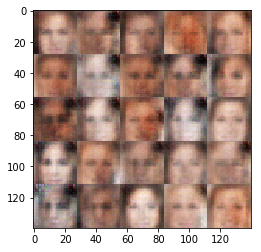

Epoch 1/1... Discriminator Loss: 0.0053... Generator Loss: 9.6040
Epoch 1/1... Discriminator Loss: 0.0101... Generator Loss: 10.8286
Epoch 1/1... Discriminator Loss: 0.0217... Generator Loss: 4.7303
Epoch 1/1... Discriminator Loss: 0.0078... Generator Loss: 11.9012
Epoch 1/1... Discriminator Loss: 0.0041... Generator Loss: 7.6784
Epoch 1/1... Discriminator Loss: 0.0143... Generator Loss: 8.0731
Epoch 1/1... Discriminator Loss: 0.0117... Generator Loss: 7.6395
Epoch 1/1... Discriminator Loss: 0.0202... Generator Loss: 5.0445
Epoch 1/1... Discriminator Loss: 0.0061... Generator Loss: 9.2529
Epoch 1/1... Discriminator Loss: 0.0110... Generator Loss: 7.4801


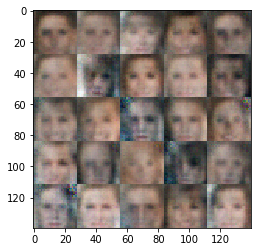

Epoch 1/1... Discriminator Loss: 0.0208... Generator Loss: 4.8614
Epoch 1/1... Discriminator Loss: 0.0404... Generator Loss: 10.2807
Epoch 1/1... Discriminator Loss: 0.0076... Generator Loss: 7.3800
Epoch 1/1... Discriminator Loss: 0.0049... Generator Loss: 8.2542
Epoch 1/1... Discriminator Loss: 0.0215... Generator Loss: 4.4783
Epoch 1/1... Discriminator Loss: 0.0146... Generator Loss: 8.3111
Epoch 1/1... Discriminator Loss: 0.0161... Generator Loss: 10.5367
Epoch 1/1... Discriminator Loss: 0.0099... Generator Loss: 7.6828


In [70]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.